In [1]:
import os
import os.path as op
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,5))

# Define experimental info and ROIs

In [3]:
smoothing = 'smoothed'
regspace = 'epi'

exp = 'mag-SVtotaldiff'

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_ifs',
       '_ains',
       '.vmpfc_']

# Main functions for extracting and analysing ROI data

In [4]:
def extract_copes(exp,regspace,smoothing,contrast):
    df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

    for sub in subs:
        cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
            '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
        cope = nib.load(cope).get_data()

        masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
        masks = [m for m in masks if any(substring in m for substring in rois)]

        for m in masks:
            if len(m.split('/')[-1].split('.'))==4:
                hemi = m.split('/')[-1].split('.')[0]
                label = m.split('/')[-1].split('.')[1]
            else:
                hemi = 'na'
                label = m.split('/')[-1].split('.')[0]

            m = nib.load(m).get_data().astype(bool)
            num_voxels = m.sum()
            func_masked = cope[m]
            row = pd.DataFrame([dict(sub = sub, 
                                     contrast =contrast, 
                                     mask_vox = num_voxels, 
                                     hemi = hemi,
                                     label = label, 
                                     value = np.mean(func_masked)), ])
            df = df.append(row, ignore_index = True)
    return df

In [43]:
def plot_fig(res,contrast):
    plt.figure(figsize=(10, 6))

    #relabel
    res = res.copy()
    res['ROI'] = [label_map[x] for x in res['label'].values]
    
    #sort dataframe
    res['ROI'] = pd.Categorical(res['ROI'],roi_plotting_order)
    res = res.sort('ROI')

    #plot
    sns.barplot(x='ROI',y='val',data = res,
                **{'yerr':res['err'],
                   'error_kw':dict(ecolor='grey', lw=2.5)}
                )
    sns.despine()
    plt.ylabel('Beta (AU)')
    plt.title(title_map[contrast])
    plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.svg')

In [44]:
def run_stats(df):
    results_df =pd.DataFrame(columns=('contrast','label','nvox',
                                      'std_vox','p_unc','val','err'))
    for roi in set(df['label']):

        new = df[df['label'] == roi]

        #run mixed effects model
        model_str = 'value ~ 1'
        mixedfx = smf.mixedlm(model_str, new, groups = new['sub'])    
        mixedfx = mixedfx.fit()
        
        #extract p value and errors
        p = mixedfx.pvalues['Intercept']
        val = mixedfx.params[0]
#         err = mixedfx.bse_fe[0] #standard error
        conf_int = mixedfx.conf_int()
        err = (conf_int.loc['Intercept',1] - conf_int.loc['Intercept',0]) / 2.0 #plots 95% conf
        
        #update dataframe
        row = pd.DataFrame([dict(contrast = title_map[contrast], 
                                 label = roi,
                                 nvox = np.mean(new['mask_vox']),
                                 val = val,
                                 err = err,
                                p_unc = p), ])
        results_df = results_df.append(row, ignore_index = True)
        
    #correct for multiple comparisons
    sig,pcorr,a1,a2 = multipletests(results_df['p_unc'],.05,method = 'fdr_tsbh')
    results_df['p_corr'] = pcorr
    results_df['sig'] = sig
    return results_df


In [45]:
def run_contrast(exp,regspace,smoothing,contrast):
    df = extract_copes(exp,regspace,smoothing,contrast)
    df['ROI'] = [label_map[x] for x in df['label'].values]
    
    df.to_csv('/home/iballard/Dropbox/Magnitude_fMRI/roi_analysis/' + exp  + '_' + contrast + '.csv',
              index = False)
    
    results = run_stats(df)
    results['ROI'] = [label_map[x] for x in results['label'].values]

    plot_fig(results,contrast)

    return results

# Set up figure aesthetics

In [46]:
label_map = {'yeo17_amfg':'aMFG','yeo17_pmfg':'pMFG','yeo17_ains':'aINS','yeo17_fpc':'FPC',
            'yeo17_ifs':'IFS','yeo17_ifg':'IFG','yeo17_psfs':'FEF','vmpfc_bartre':'vmPFC'}
roi_plotting_order = ['IFS','FPC','pMFG','FEF','aINS','IFG','aMFG','vmPFC']

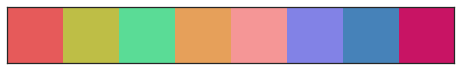

In [47]:
#get colors from ROI figure and match them
ctab = '/home/iballard/mag/data/fsaverage/label/pfc.ctab'
color = np.loadtxt(ctab,object)
custom_palette = []
for row in color:
    rgb = (int(row[2]),int(row[3]),int(row[4]))
    hex_rgb = '#%02x%02x%02x' % rgb
    roi_id = label_map[row[1]]
    custom_palette.append((hex_rgb, roi_id))

custom_palette.sort(key=lambda x: roi_plotting_order.index(x[1]))
custom_palette = [x[0] for x in custom_palette]

sns.set_palette(custom_palette)
sns.palplot(sns.color_palette())

In [10]:
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [11]:
#for figure plotting
title_map = {'decision': 'Decision Period', 
             'SV_total': 'Subjective Value',
             'neg_SV_diff': 'Difficulty',
             'low_minus_high_SV_diff': 'Difficulty (High minus Low Magnitude)',
             'high_minus_low_SV': 'Subjective Value (High minus Low Magnitude)',
            'high_minus_low': 'High minus Low Magnitude'}
contrasts = title_map.keys()

# Run analysis

In [195]:
all_results = []

for contrast in contrasts:
    results = run_contrast(exp,regspace,smoothing,contrast)
    all_results.append(results.copy())
    
all_results = pd.concat(all_results)
all_results = all_results.set_index(['contrast'])

In [42]:
all_results.to_csv('/home/iballard/Dropbox/mag_figs/roi_results.csv',index = False)
all_results[['ROI','p_unc','p_corr','sig']]

,ROI,p_unc,p_corr,sig
contrast,,,,
Subjective Value,IFG,5.069563e-01,6.159608e-01,False
Subjective Value,FPC,8.434879e-01,7.380519e-01,False
Subjective Value,aMFG,4.175301e-01,6.159608e-01,False
Subjective Value,aINS,8.087778e-01,7.380519e-01,False
Subjective Value,IFS,3.896351e-02,1.363723e-01,False
Subjective Value,pMFG,2.687953e-01,6.159608e-01,False
Subjective Value,vmPFC,1.755664e-03,1.228965e-02,True
Subjective Value,FEF,5.279664e-01,6.159608e-01,False
Decision Period,IFG,6.289789e-07,4.717342e-07,True


# Run brain-behavior correlation

In [138]:
#load data
params = pd.read_csv('/home/iballard/Dropbox/mag_figs/model_fits.csv')
params = params[params['sub'] != 'asu09'] #subject excluded for strong anti-magnitude effect
params = params.reset_index()

#fix subject id coding
for n,s in enumerate(params['sub']):
    if s == 'asu04':
        params.loc[n,'sub'] = 'asu4'
    if s == 'asu08':
        params.loc[n,'sub'] = 'asu8'

In [139]:
params['mag_effect'] = [(np.log(low) - np.log(high)) for low,high in zip(params['k_low'],params['k_high'])]

In [190]:
contrast = 'low_minus_high_SV_diff'
ROI = 'IFS'

In [191]:
#extract data
df = extract_copes(exp,regspace,smoothing,contrast)
df['ROI'] = [label_map[x] for x in df['label'].values]
df.set_index('ROI').loc[ROI]
df = df.groupby('sub').mean().reset_index()

In [192]:
df = pd.merge(df,
         params,
        how = 'left',
        on = 'sub')

In [193]:
exog = statsmodels.tools.add_constant(df['mag_effect'])
huber_t = smf.RLM(df['value'], exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print hub_results.summary()

                    Robust linear Model Regression Results                    
Dep. Variable:                  value   No. Observations:                   19
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Apr 2017                                         
Time:                        14:38:53                                         
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.6385      0.934     -0.683      0.4

In [194]:
res = smf.OLS(df['value'], exog)
res = res.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.058
Date:                Wed, 05 Apr 2017   Prob (F-statistic):              0.170
Time:                        14:38:53   Log-Likelihood:                -28.944
No. Observations:                  19   AIC:                             61.89
Df Residuals:                      17   BIC:                             63.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.6285      0.879     -0.715      0.4